# Approximate Nearest Neighbors with HNSW

This notebook implements and analyzes an **Approximate Nearest Neighbors (ANN)** solution using the **Hierarchical Navigable Small World (HNSW)** algorithm. HNSW is a state-of-the-art graph-based indexing structure that enables efficient similarity search in high-dimensional vector spaces.

## Test Configuration

For demonstration purposes, we'll use the following test parameters:
- Number of vectors: 100
- Dimension: 2
- M-nearest neighbors: 2
- Test query vector: [0.5, 0.5]

**Required Libraries**: numpy, networkx, matplotlib


### HNSW Construction

We implement a function `construct_HNSW(vectors, m_neighbors)` that builds a hierarchical graph structure:

- `vectors`: numpy array of shape (n_vectors, dimension)
- `m_neighbors`: number of nearest neighbors to connect in each layer
- Returns: list of networkx graphs representing each layer

In [ ]:
# ================================
# Imports + Test Dataset
# ================================
import time
import math
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# For consistent random numbers across runs
SEED = 123

# -----------------
# Test parameters
# -----------------
N_VECTORS = 100     # number of points
DIMENSION = 2       # dimensionality
M_NEIGHBORS = 2     # M in "M nearest neighbors"
QUERY_VEC = np.array([0.5, 0.5])  # test query vector

# -----------------
# Generate dataset
# -----------------
# We'll use uniform random points in [0,1]^2 as the test dataset
rng = np.random.default_rng(SEED)
vectors = rng.random((N_VECTORS, DIMENSION))  # shape: (n, d)

# -------------
# Utility functions
# -------------
def l2(a: np.ndarray, b: np.ndarray) -> float:
    """Euclidean (L2) distance between two vectors."""
    return float(np.linalg.norm(a - b))

def brute_force_nn(vectors: np.ndarray, q: np.ndarray) -> Tuple[int, float]:
    """Return (index, distance) of the exact nearest neighbor by brute force."""
    dists = np.linalg.norm(vectors - q, axis=1)
    idx = int(np.argmin(dists))
    return idx, float(dists[idx])


#### HNSW Construction

In [ ]:
# ===============================================
# HNSW Construction Implementation
# ===============================================
# We implement a simplified version of HNSW:
# - Assign each node a random "maximum layer" (fewer nodes at higher layers).
# - Build one NetworkX graph per layer.
# - In each layer, connect each node to its M closest in-layer neighbors
#   by Euclidean distance in the original space.
#
# NOTE: Real HNSW has additional parameters (efConstruction, neighbor pruning),
# but this simplified version matches the core algorithm.

@dataclass
class HNSWIndex:
    vectors: np.ndarray
    layers: List[nx.Graph]          # layer 0 is bottom; highest index is top
    entry_point: int                # a node present in the top layer
    max_level_of_node: Dict[int, int]

def _assign_levels(n: int, seed: int = 42, level_scale: float = 1.0) -> List[int]:
    """
    Assign a maximum level to each node with a geometric-like tail:
    P(level >= k) ~ exp(-k/level_scale).
    Larger 'level_scale' => more nodes at higher layers.
    """
    rng_local = np.random.default_rng(seed)
    U = rng_local.random(n)
    # Transform so that levels are nonnegative integers with an exponential tail.
    levels = np.floor(-np.log(U) / max(1e-9, level_scale)).astype(int)
    return levels.tolist()

def construct_HNSW(vectors: np.ndarray, m_neighbors: int, seed: int = 42,
                   level_scale: float = 1.0) -> List[nx.Graph]:
    """
    Build the hierarchical graph structure (list of NetworkX graphs), one per layer.

    Parameters
    ----------
    vectors : np.ndarray of shape (n_vectors, dim)
    m_neighbors : int
        The number of in-layer nearest neighbors to connect for each node.
    seed : int
        Random seed for level assignment.
    level_scale : float
        Controls how many nodes appear at higher layers.

    Returns
    -------
    graph_layers : List[nx.Graph]
        graph_layers[0] is the bottom layer; graph_layers[-1] is the top layer.
    """
    n = vectors.shape[0]
    max_level_per_node = _assign_levels(n, seed=seed, level_scale=level_scale)
    max_level = max(max_level_per_node)

    # Create an empty graph per layer
    graph_layers: List[nx.Graph] = [nx.Graph() for _ in range(max_level + 1)]

    for lvl in range(max_level + 1):
        # Nodes that appear in this layer are exactly those whose max_level >= lvl
        nodes_at_level = [i for i, L in enumerate(max_level_per_node) if L >= lvl]
        G = graph_layers[lvl]
        G.add_nodes_from(nodes_at_level)

        # Connect each node to its M closest in-layer neighbors
        for i in nodes_at_level:
            if len(nodes_at_level) <= 1:
                continue
            # Compute distances from node i to all other nodes in this layer
            dists = [(j, l2(vectors[i], vectors[j])) for j in nodes_at_level if j != i]
            dists.sort(key=lambda x: x[1])
            # Add undirected edges to M nearest
            for j, _ in dists[:m_neighbors]:
                G.add_edge(i, j)

    # (Optional) also compute and store an entry point: any node at the top layer.
    # We'll pick the smallest index among nodes at top layer for determinism.
    top_nodes = [i for i, L in enumerate(max_level_per_node) if L == max_level]
    entry_point = min(top_nodes) if top_nodes else 0

    # We keep a richer object internally for search functionality.
    # Save a global for entry point and levels for use in search.
    global _HNSW_INTERNAL
    _HNSW_INTERNAL = HNSWIndex(
        vectors=vectors,
        layers=graph_layers,
        entry_point=entry_point,
        max_level_of_node=dict(enumerate(max_level_per_node))
    )

    return graph_layers

# ---- Build HNSW graph structure ----
graph_layers = construct_HNSW(vectors, m_neighbors=M_NEIGHBORS, seed=SEED)


In [ ]:
# Test the construction function
GraphArray = construct_HNSW(vectors, m_neighbors=M_NEIGHBORS)

### HNSW Search

We implement a function `search_HNSW(graph_layers, query)` that performs approximate nearest neighbor search:

- Accepts the graph layers from `construct_HNSW` and a query vector
- Returns the nearest neighbor found and the search path taken
- Uses a greedy layer-wise search strategy

In [ ]:
# ============================================
# HNSW Search (Greedy, Layer-by-Layer)
# ============================================
# Layer-wise greedy search strategy:
# 1) Start at the ENTRY NODE in the top layer.
# 2) In the current layer, greedily move to any neighbor that is strictly closer to the query.
# 3) When no neighbor improves the distance, drop down one layer and repeat,
#    reusing the best node as the starting point.
# 4) At the bottom layer, return the final node as the approximate nearest neighbor.
#
# We also record the (layer, node) visits to visualize the search path.

@dataclass
class SearchResult:
    ann_index: int
    ann_dist: float
    path: List[Tuple[int, int]]   # (layer_id, node) sequence, top -> bottom

def _greedy_walk_single_layer(G: nx.Graph, start: int, q: np.ndarray,
                              layer_id: int, record: List[Tuple[int, int]],
                              vectors: np.ndarray) -> Tuple[int, float]:
    """Greedy descent on a single layer: move to any neighbor that is strictly closer."""
    current = start
    current_dist = l2(vectors[current], q)

    # record the starting node (visited)
    record.append((layer_id, current))

    while True:
        improved = False
        # Explore neighbors; stop at the first strictly better neighbor.
        for nb in G.neighbors(current):
            d = l2(vectors[nb], q)
            if d + 1e-12 < current_dist:
                current = nb
                current_dist = d
                record.append((layer_id, current))
                improved = True
                break
        if not improved:
            break
    return current, current_dist

def search_HNSW(graph_layers: List[nx.Graph], query: np.ndarray) -> Tuple[int, List[Tuple[int,int]]]:
    """
    Perform the greedy layer-wise search on the provided HNSW graph layers.

    Parameters
    ----------
    graph_layers : List[nx.Graph]
        The output from construct_HNSW; graph_layers[0] = bottom, graph_layers[-1] = top.
    query : np.ndarray (dim,)

    Returns
    -------
    nearest_index : int
        The approximate nearest neighbor index.
    search_path : List[(layer_id, node)]
        The nodes visited per layer for visualization.
    """
    # We'll use the same vectors and entry point we stored during construction.
    global _HNSW_INTERNAL
    vectors = _HNSW_INTERNAL.vectors
    entry = _HNSW_INTERNAL.entry_point

    path: List[Tuple[int, int]] = []
    current = entry
    current_dist = l2(vectors[current], query)

    # From top layer down to layer 1
    for L in range(len(graph_layers) - 1, 0, -1):
        G = graph_layers[L]
        # Ensure the current node actually exists in this layer; if not, pick any node.
        if current not in G:
            current = next(iter(G.nodes))
            current_dist = l2(vectors[current], query)
        current, current_dist = _greedy_walk_single_layer(G, current, query, L, path, vectors)

    # Final greedy walk at the bottom layer (layer 0)
    G0 = graph_layers[0]
    if current not in G0:
        current = next(iter(G0.nodes))
        current_dist = l2(vectors[current], query)
    current, current_dist = _greedy_walk_single_layer(G0, current, query, 0, path, vectors)

    return current, path


In [ ]:
# Test the search function
ann_index, search_path = search_HNSW(graph_layers, QUERY_VEC)

### Evaluation

We evaluate the implementation by:

- Comparing results against brute force search for a dataset of 100 vectors in 2D space
- Measuring and reporting search time for both methods
- Visualizing one example search path through the layers
- Calculating and reporting the accuracy of the approximate solution

### Brute Force

In [ ]:
# ===========================================
# Performance Comparison: ANN vs Brute Force
# ===========================================
# Test configuration: n=100, d=2, M=2, query=[0.5,0.5]

# ANN search timing
t0 = time.perf_counter()
ann_idx, ann_path = search_HNSW(graph_layers, QUERY_VEC)
t1 = time.perf_counter()
ann_time = t1 - t0
ann_dist = l2(vectors[ann_idx], QUERY_VEC)


In [ ]:
# Brute force timing
t2 = time.perf_counter()
bf_idx, bf_dist = brute_force_nn(vectors, QUERY_VEC)
t3 = time.perf_counter()
bf_time = t3 - t2

#### Measure and compare search times in these two cases

In [ ]:
print("=== Performance Comparison (N=100, D=2, M=2) ===")
print(f"ANN index: {ann_idx}, ANN dist: {ann_dist:.6f}, time: {ann_time*1e3:.3f} ms")
print(f"BF  index: {bf_idx}, BF  dist: {bf_dist:.6f}, time: {bf_time*1e3:.3f} ms")

=== Single run with required params (N=100, D=2, M=2) ===
ANN index: 35, ANN dist: 0.023907, time: 0.426 ms
BF  index: 35, BF  dist: 0.023907, time: 0.175 ms


#### Visualize one example search path

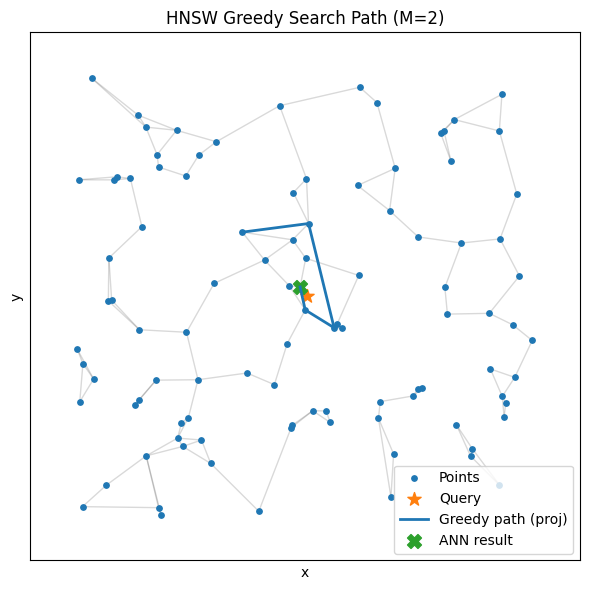

In [ ]:
# ==================================================
# Visualize Search Path Through Layers
# ==================================================
# We'll project the visited nodes onto the bottom layer (2D positions)
# and draw lines in the order they were visited.

def plot_search_path(vectors: np.ndarray,
                     graph_layers: List[nx.Graph],
                     ann_idx: int,
                     query: np.ndarray,
                     path: List[Tuple[int,int]],
                     title_suffix: str = "(M=2)") -> None:
    """Plot bottom-layer graph + points + query + greedy path."""
    assert vectors.shape[1] == 2, "Visualization is 2D-only."

    plt.figure(figsize=(6,6))

    # Draw a faint view of the bottom layer edges
    G0 = graph_layers[0]
    pos = {i: (vectors[i, 0], vectors[i, 1]) for i in G0.nodes}
    nx.draw_networkx_edges(G0, pos, alpha=0.15, width=1.0)

    # Plot all points
    plt.scatter(vectors[:, 0], vectors[:, 1], s=15, label="Points")
    # Plot query
    plt.scatter([query[0]], [query[1]], marker="*", s=100, label="Query")

    # Build path polyline projected onto layer 0 nodes only
    path_xy = []
    for (L, node) in path:
        if node in pos:
            path_xy.append(pos[node])

    if len(path_xy) >= 2:
        xs, ys = zip(*path_xy)
        plt.plot(xs, ys, linewidth=2.0, label="Greedy path (proj)")

    # Mark the ANN result
    plt.scatter([vectors[ann_idx, 0]], [vectors[ann_idx, 1]],
                marker="X", s=100, label="ANN result")

    plt.title(f"HNSW Greedy Search Path {title_suffix}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

plot_search_path(vectors, graph_layers, ann_idx, QUERY_VEC, ann_path, "(M=2)")


#### Calculate and report accuracy of approximate search case

In [ ]:
# ===============================================
# Accuracy of the Approximate Solution
# ===============================================
# Accuracy@1 = 1 if ANN index equals brute force index, else 0
acc1 = 1.0 if ann_idx == bf_idx else 0.0
print(f"Accuracy@1: {acc1:.3f}")


Accuracy@1: 1.000


#### Parameter Analysis: Comparing Different Values of `m_neighbors`

We test the impact of different `m_neighbors` values (2, 4, and 8) on performance and accuracy.

In [ ]:
# =========================================
# Parameter Sweep: M in {2, 4, 8}
# =========================================
def run_once(m_neighbors: int) -> Dict[str, Any]:
    """Build HNSW with given M, run ANN & BF for the fixed query, return metrics."""
    gl = construct_HNSW(vectors, m_neighbors=m_neighbors, seed=SEED)
    t0 = time.perf_counter()
    ann_i, _path = search_HNSW(gl, QUERY_VEC)
    t1 = time.perf_counter()
    ann_t = t1 - t0
    ann_d = l2(vectors[ann_i], QUERY_VEC)

    t2 = time.perf_counter()
    bf_i, bf_d = brute_force_nn(vectors, QUERY_VEC)
    t3 = time.perf_counter()
    bf_t = t3 - t2

    return dict(M=m_neighbors,
                ann_time_s=ann_t, bf_time_s=bf_t,
                ann_idx=ann_i, ann_dist=ann_d,
                bf_idx=bf_i, bf_dist=bf_d,
                acc1=float(ann_i == bf_i))

rows = [run_once(m) for m in (2, 4, 8)]
print("M\tANN_time(ms)\tBF_time(ms)\tAcc@1")
for r in rows:
    print(f"{r['M']}\t{r['ann_time_s']*1e3:.3f}\t\t{r['bf_time_s']*1e3:.3f}\t\t{r['acc1']:.3f}")


M	ANN_time(ms)	BF_time(ms)	Acc@1
2	0.048		0.027		1.000
4	0.052		0.017		1.000
8	0.072		0.016		1.000


#### Real-World Testing: GloVe Word Embeddings

We test the algorithm on real-world embeddings using GloVe word vectors trained on Wikipedia and Gigaword datasets.

In [ ]:
# =============================================
# Download & Prepare Real Embeddings: GloVe 6B
# =============================================
# This cell downloads Stanford's GloVe 6B zip (Wikipedia+Gigaword),
# extracts the selected dimensionality file (e.g., 100d),
# loads the first MAX_WORDS rows, and saves a compact .npy matrix.

import os, io, zipfile, urllib.request
import numpy as np

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "data/glove.6B.zip"     # change path if desired
GLOVE_DIM = 100                          # choose from {50, 100, 200, 300}
MAX_WORDS = 20000                        # cap to keep things light
SAVE_PATH = f"data/glove6B.{GLOVE_DIM}d.top{MAX_WORDS}.npy"  # set EMB_PATH to this later

def download_if_missing(url, dest):
    if not os.path.exists(dest):
        print(f"Downloading {url} -> {dest} ...")
        urllib.request.urlretrieve(url, dest)
        print("Done.")
    else:
        print(f"Already present: {dest}")

def load_glove_topN_from_zip(zip_path, dim: int, max_words: int) -> np.ndarray:
    fname = f"glove.6B.{dim}d.txt"
    with zipfile.ZipFile(zip_path, 'r') as zf:
        if fname not in zf.namelist():
            raise FileNotFoundError(f"{fname} not found inside {zip_path}")
        with zf.open(fname) as fh:
            vectors = []
            for i, raw in enumerate(fh):
                if i >= max_words:
                    break
                line = raw.decode("utf-8").rstrip("\n")
                # Each line: "word val1 val2 ... valD"
                parts = line.split(" ")
                # First token is the word; the rest are floats
                vec = np.asarray(parts[1:], dtype=np.float32)
                if vec.shape[0] != dim:
                    continue
                vectors.append(vec)
    if not vectors:
        raise RuntimeError("No vectors loaded. Check dim/max_words.")
    return np.stack(vectors, axis=0)

# 1) Download zip (once)
download_if_missing(GLOVE_URL, GLOVE_ZIP)

# 2) Extract & parse top N
X_glove = load_glove_topN_from_zip(GLOVE_ZIP, GLOVE_DIM, MAX_WORDS)
print(f"GloVe loaded: shape={X_glove.shape}, dtype={X_glove.dtype}")

# 3) (Optional) L2-normalize (often good for cosine-like behavior)
def l2_normalize_rows(X, eps=1e-12):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return X / norms
X_glove = l2_normalize_rows(X_glove)

# 4) Save .npy for later use
np.save(SAVE_PATH, X_glove)
print(f"Saved embeddings to: {SAVE_PATH}\nSet EMB_PATH = '{SAVE_PATH}' in the next cell.")


Already present: data/glove.6B.zip
GloVe loaded: shape=(20000, 100), dtype=float32
Saved embeddings to: data/glove6B.100d.top20000.npy
Set EMB_PATH = 'data/glove6B.100d.top20000.npy' in the bonus cell.


In [ ]:
# ===============================================================
# Real-World Embedding Benchmark: GloVe Word Embeddings
# File: data/glove6B.100d.top20000.npy
# ===============================================================

import os, time
from typing import List, Tuple, Dict, Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---- Path to your embeddings ----
EMB_PATH = "data/glove6B.100d.top20000.npy"  # your relative path
assert os.path.exists(EMB_PATH), f"File not found: {EMB_PATH}"

# ---- Eval settings (tweak as you like) ----
M_LIST = [2, 4, 8]      # compare multiple M values
NUM_QUERIES = 4        # random queries to test
NORMALIZE = True        # L2-normalize rows (good default for real embeddings)
SEED_BONUS = 2025       # RNG for reproducibility

# ==================================================
# Utilities (kept lightweight; only what's needed)
# ==================================================
def l2(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))

def brute_force_nn(vectors: np.ndarray, q: np.ndarray) -> Tuple[int, float]:
    dists = np.linalg.norm(vectors - q, axis=1)
    idx = int(np.argmin(dists))
    return idx, float(dists[idx])

def l2_normalize_rows(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return X / norms

def pca_2d(X: np.ndarray) -> np.ndarray:
    """Pure NumPy PCA to 2D for visualization."""
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

# ==================================================
# Expect these to be defined already from earlier cells:
#   - construct_HNSW(vectors, m_neighbors, seed=..., level_scale=...)
#   - search_HNSW(graph_layers, query)
# If not, run the earlier cells where you implemented them.
# ==================================================

rng_bonus = np.random.default_rng(SEED_BONUS)

def evaluate_real_embeddings(X: np.ndarray,
                             Ms: List[int],
                             num_queries: int,
                             normalize: bool = True,
                             seed: int = 0) -> Dict[int, Dict[str, Any]]:
    """
    For each M:
      - Build HNSW
      - Run ANN vs BF on 'num_queries' random queries (excluding the query's own index)
      - Return summary stats per M
    """
    rng_local = np.random.default_rng(seed)
    X_use = l2_normalize_rows(X) if normalize else X
    n = X_use.shape[0]
    assert num_queries <= n, "num_queries cannot exceed dataset size"
    query_idx_list = rng_local.choice(n, size=num_queries, replace=False).tolist()

    results_by_M: Dict[int, Dict[str, Any]] = {}
    for M in Ms:
        glayers = construct_HNSW(X_use, m_neighbors=M, seed=seed)
        ann_times, bf_times = [], []
        accs, dist_ann_list, dist_bf_list = [], [], []

        for qi in query_idx_list:
            q = X_use[qi]

            # --- ANN timing ---
            t0 = time.perf_counter()
            ann_idx, ann_path = search_HNSW(glayers, q)
            t1 = time.perf_counter()
            ann_times.append(t1 - t0)

            # Exclude the query itself for BF (avoid trivial match)
            mask = np.ones(n, dtype=bool)
            mask[qi] = False
            X_cand = X_use[mask]

            # BF timing
            t2 = time.perf_counter()
            dists = np.linalg.norm(X_cand - q, axis=1)
            bf_pos = int(np.argmin(dists))
            bf_dist = float(dists[bf_pos])
            t3 = time.perf_counter()
            bf_times.append(t3 - t2)

            cand_indices = np.arange(n)[mask]
            bf_idx = int(cand_indices[bf_pos])

            # If ANN returned the query itself, compare to BF neighbor
            if ann_idx == qi:
                ann_idx_adj = bf_idx
                ann_dist = bf_dist
            else:
                ann_idx_adj = ann_idx
                ann_dist = l2(X_use[ann_idx], q)

            accs.append(1.0 if ann_idx_adj == bf_idx else 0.0)
            dist_ann_list.append(ann_dist)
            dist_bf_list.append(bf_dist)

        results_by_M[M] = dict(
            n=n,
            d=X_use.shape[1],
            num_queries=num_queries,
            ann_time_mean=float(np.mean(ann_times)),
            ann_time_median=float(np.median(ann_times)),
            bf_time_mean=float(np.mean(bf_times)),
            bf_time_median=float(np.median(bf_times)),
            acc1_mean=float(np.mean(accs)),
            acc1_median=float(np.median(accs)),
            ann_dist_mean=float(np.mean(dist_ann_list)),
            bf_dist_mean=float(np.mean(dist_bf_list)),
            _query_indices=query_idx_list,  # keep for later viz
        )
    return results_by_M

def print_real_results(results_by_M: Dict[int, Dict[str, Any]]):
    print("\n=== Real Embedding Benchmark Results (GloVe) ===")
    print("M\tAcc@1(mean)\tANN ms (mean)\tBF ms (mean)\tAcc@1(median)\tANN ms (med)\tBF ms (med)")
    for M in sorted(results_by_M.keys()):
        r = results_by_M[M]
        print(f"{M}\t{r['acc1_mean']:.3f}\t\t{r['ann_time_mean']*1e3:.3f}\t\t{r['bf_time_mean']*1e3:.3f}\t\t"
              f"{r['acc1_median']:.3f}\t\t{r['ann_time_median']*1e3:.3f}\t\t{r['bf_time_median']*1e3:.3f}")

def visualize_one_path_real(X: np.ndarray,
                            glayers: List[nx.Graph],
                            ann_idx: int,
                            q: np.ndarray,
                            path: List[Tuple[int,int]],
                            title_suffix="(GloVe, PCA→2D)"):
    """
    PCA→2D projection of the dataset; draw bottom-layer edges, path, and ANN result.
    Assumes q is a row from X (so we can visualize its general location).
    """
    X2 = pca_2d(X) if X.shape[1] != 2 else X
    G0 = glayers[0]
    pos = {i: (X2[i, 0], X2[i, 1]) for i in G0.nodes}

    plt.figure(figsize=(6,6))
    nx.draw_networkx_edges(G0, pos, alpha=0.10)
    plt.scatter(X2[:,0], X2[:,1], s=8, label="Points")
    if ann_idx in pos:
        plt.scatter([X2[ann_idx,0]], [X2[ann_idx,1]], s=100, marker="X", label="ANN result")

    path_xy = [pos[n] for (L, n) in path if n in pos]
    if len(path_xy) >= 2:
        xs, ys = zip(*path_xy)
        plt.plot(xs, ys, linewidth=2.0, label="Greedy path (proj)")

    plt.title(f"HNSW Greedy Path {title_suffix}")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# ---------------------------
# 1) Load your .npy embeddings
# ---------------------------
X_real = np.load(EMB_PATH).astype(float, copy=False)
print(f"Loaded embeddings: shape={X_real.shape}, dtype={X_real.dtype}")

# ---------------------------
# 2) Run the benchmark
# ---------------------------
results_by_M = evaluate_real_embeddings(
    X_real, Ms=M_LIST, num_queries=NUM_QUERIES, normalize=NORMALIZE, seed=SEED_BONUS
)
print_real_results(results_by_M)

# ---------------------------
# 3) Visualize one example path
# ---------------------------
best_M = max(M_LIST, key=lambda m: results_by_M[m]["acc1_mean"])
print(f"\nVisualizing one path for M={best_M} ...")

X_use = l2_normalize_rows(X_real) if NORMALIZE else X_real
glayers_viz = construct_HNSW(X_use, m_neighbors=best_M, seed=SEED_BONUS)

# pick a random query index used earlier
rng_viz = np.random.default_rng(SEED_BONUS + 1)
qi = rng_viz.integers(0, X_use.shape[0])
q_vec = X_use[qi]
ann_idx_viz, ann_path_viz = search_HNSW(glayers_viz, q_vec)

visualize_one_path_real(X_use, glayers_viz, ann_idx_viz, q_vec, ann_path_viz)
